In [1]:
# torch 및 torchaudio 라이브러리 설치
!pip install torch
!pip install torchaudio
!pip install librosa

Looking in indexes: http://ftp.daumkakao.com/pypi/simple
Looking in indexes: http://ftp.daumkakao.com/pypi/simple
Looking in indexes: http://ftp.daumkakao.com/pypi/simple


In [2]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchaudio

In [3]:
# 용량 초과 관계로 직접 다운로드 받아 사용하는 방식으로 할 것 (331MB)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

In [4]:
test_dataset[0]

(tensor([[0.0003, 0.0003, 0.0004,  ..., 0.0021, 0.0021, 0.0016]]),
 16000,
 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE',
 1089,
 134686,
 0)

In [5]:
# 음성 데이터 예제를 바탕으로 실습 진행
audioData = test_dataset[0][0][0] # [0]만 했을 때 shape 가 (1, ?) 으로 뜸.
sr = test_dataset[0][1] # Sampling Rate
# nyquist-shannon sampling theorem 을 바탕으로 A/D를 거치고, D/A로 복원하기 위해서는
# 표본화 된 신호의 최대 주파수가 두 배 보다 더 클 때 가능하다고 함.
# 정리하여, 최대 Frequency 의 절반으로 설정.
# 통상적으로, 16KHz(Speech), 22.05KHz, 44.1KHz (Music)
audioData, audioData.shape

(tensor([0.0003, 0.0003, 0.0004,  ..., 0.0021, 0.0021, 0.0016]),
 torch.Size([166960]))

In [6]:
len(audioData) / sr # duration (시간 단위)

10.435

In [7]:
import IPython.display as ipd
ipd.Audio(audioData, rate=sr) # Sound Player

In [8]:
# Resampling using interpolation low-pass filter
y_8k = librosa.resample(audioData.numpy(), sr, 8000)
ipd.Audio(y_8k, rate=8000)

C:\Users\devtae\AppData\Local\Temp/ipykernel_6704/1727624607.py:2: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_8k = librosa.resample(audioData.numpy(), sr, 8000)


In [9]:
len(y_8k) / 8000

10.435

In [10]:
# Resampling using interpolation low-pass filter
y_4k = librosa.resample(audioData.numpy(), sr, 4000)
ipd.Audio(y_4k, rate=4000)

C:\Users\devtae\AppData\Local\Temp/ipykernel_6704/472377201.py:2: FutureWarning: Pass orig_sr=16000, target_sr=4000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y_4k = librosa.resample(audioData.numpy(), sr, 4000)


In [11]:
len(y_4k) / 4000

10.435

(166960,)


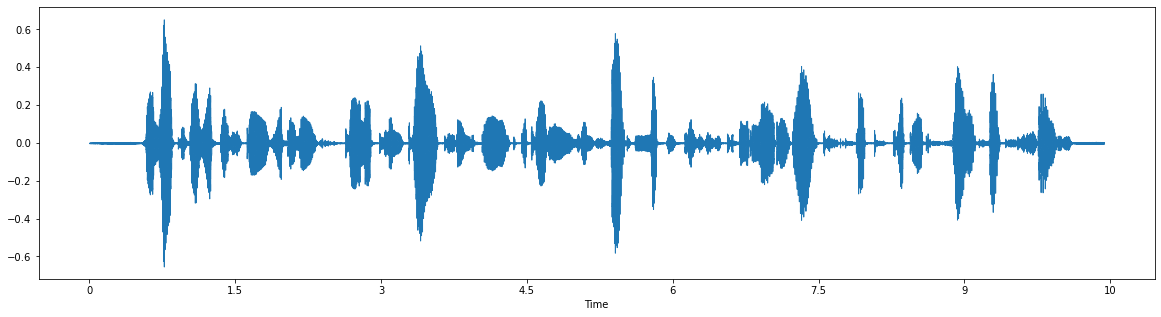

In [50]:
import librosa.display

audio_np = audioData.numpy() # tensorflow array -> numpy 변환
print(audio_np.shape)

fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(audio_np, sr=sr)

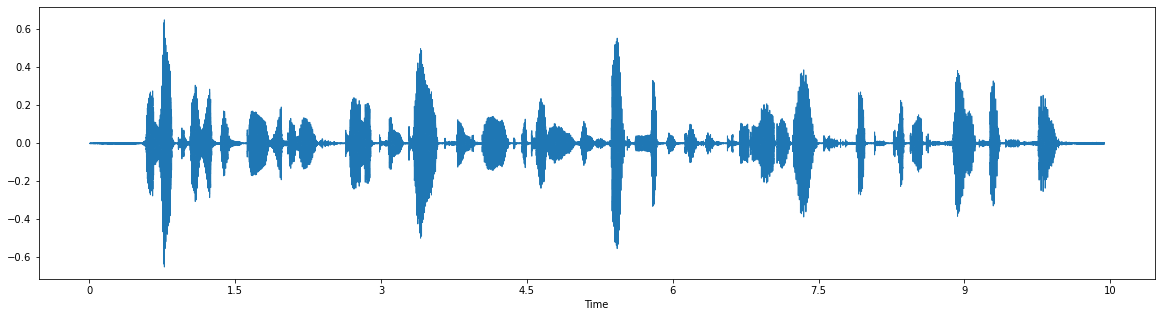

In [13]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(y_8k, sr=8000) # sr = 8000 으로 리샘플링한 음성 데이터의 waveshow 출력 / 잔파동에 대한 수치가 줄어듦

In [14]:
# Normalization

audio_np = audioData.numpy()
normed_wav = audio_np / max(np.abs(audio_np)) # 전부를 최댓값으로 나눔
ipd.Audio(normed_wav, rate=sr)

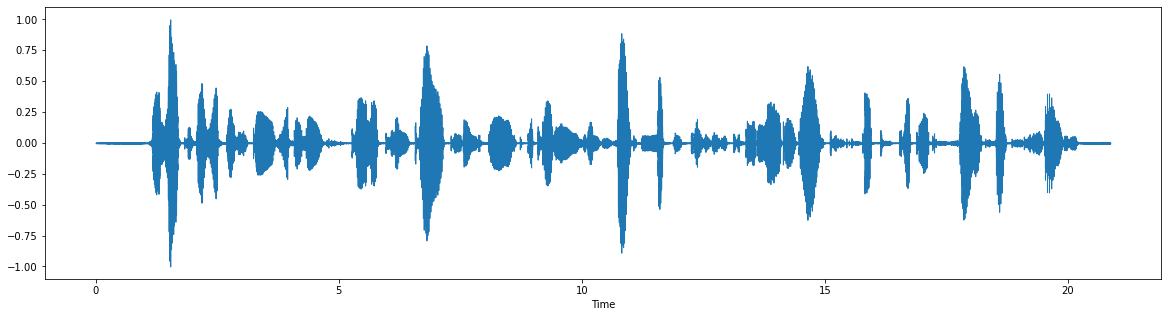

In [15]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(normed_wav, sr=8000) # -1 ~ 1 사이에 데이터가 포함되어 있는 것을 확인할 수 있음

In [16]:
# Quantization
# 큰 데이터 다루거나 네트워크가 라이트 모델의 경우 Quantization 이 필요함
# 데이터가 경량화되지만 그만큼 노이즈가 생기기도 함 (기계음 발생)

# B bit의 Quantization : -2^(B-1) ~ 2^(B-1) - 1
# Audio CD의 Quantization (16bits) : -2^(15) ~ 2^15 - 1
# 위 값들은 보통 -1.0 ~ 1.0 영역으로 scaling 되기도 한다.

Bit = 4
max_value = 2 ** (Bit - 1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav)#.astype(int) # waveshow 함수를 호출하기 위해서는 데이터가 floating value 여야 함
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value - 1) # clip 함수는 범위 바깥 수치를 수정해주는 것임
ipd.Audio(quantized_8_wav, rate=sr)

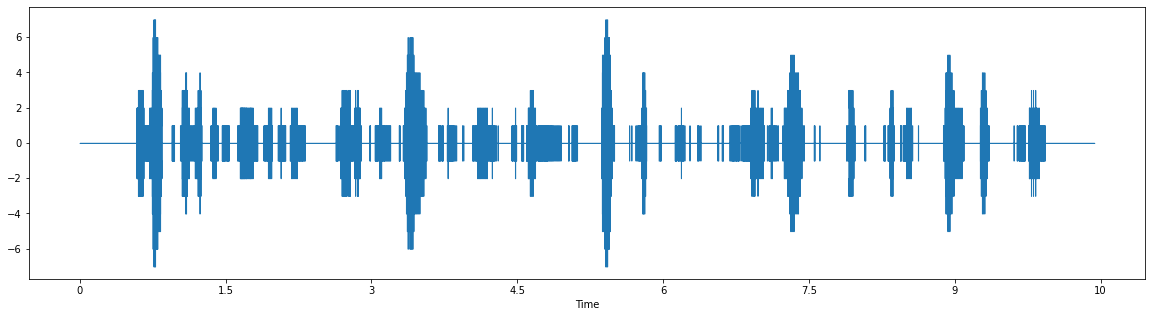

In [17]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(quantized_8_wav, sr=sr) # 값이 엄청나게 경량화된 것을 확인할 수 있음

In [18]:
# Amplitude(Intensity) : 진폭
# Frequency : 주파수
# Phase (Degress of fdisplacement) : 위상

# 복합파(Complex wave)는 복수의 서로 다른 정현파들의 합으로 이루어진 파형임

# 정현파(Sinusoid) : 일종의, 복소수가 있는 주기함수 x(n) ~= sum(k=0~K)(amplitude(n) * cos(phase(n)) + e(n)
# amplitude(n) : instantaneous amplitude (소리의 크기)
# phase(n) : instantaneous phase (복소수 영역 / 위상(Phase), 그리고 Frequency 값도 들어가야 함)
# e(n) : residual (noise)
# -----
# sum : t/fs
# amplitude(n) : Int 처리
# cos : np.cos
# phase(n) : np.pi (+ Frequency 처리)

In [19]:
# 정현파 생성
A = 0.9 # Amplitude
f = 440 # Frequency (음 : 라) / 진동수 올라갈수록 음 높아짐
phi = np.pi/2 # pie/2
fs = 22050 # sampling rate
t = 1 # 1초

In [20]:
def Sinusoid(A, f, phi, fs, t):
    t = np.arange(0, t, 1.0/fs) # 0 부터 t 까지 1.0/fs 만큼의 증가를 바탕으로 나열된 수열이 만들어짐
    x = A * np.cos(2 * np.pi * f * t + phi) # np.cos 함수 안에 들어가 있는 인자가 phase(n) 과 동일함
    return x

In [21]:
sin = Sinusoid(A, f, phi, fs, t)
print(sin)
ipd.Audio(sin, rate=fs)

[ 5.51091060e-17 -1.12545471e-01 -2.23324063e-01 ...  3.30596635e-01
  2.23324063e-01  1.12545471e-01]


In [22]:
# 복합파 생성
sin1 = Sinusoid(0.9, 200, phi, fs, t)
sin2 = Sinusoid(0.9, 400, phi, fs, t)
sin3 = Sinusoid(0.9, 800, phi, fs, t)
complexwave = sin1 + sin2 + sin3

ipd.Audio(complexwave, rate=fs) # 440, 460, 480 조합으로 했을 때, 마치 통화 연결음 같은 소리가 들림

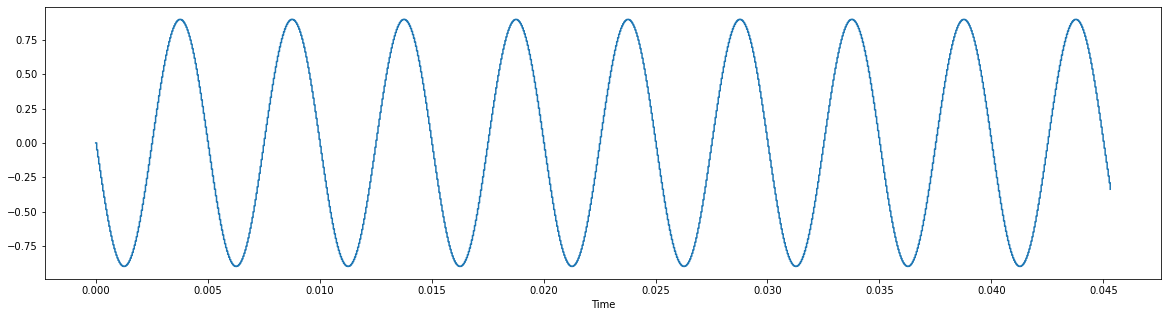

In [23]:
# 각각의 정현파 출력
# 전체 파동을 그리면 전체를 꽉 채우는 그림이 나오기에 일부만 출력하도록 하였음
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(sin1[0:1000], sr=22050)

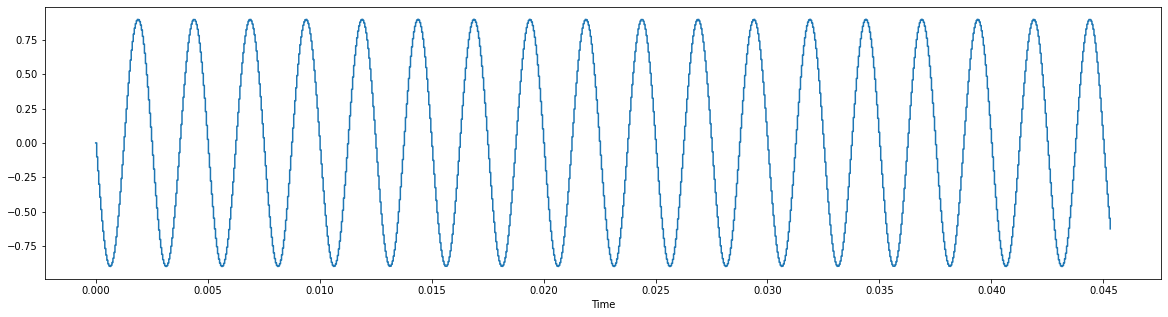

In [24]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(sin2[0:1000], sr=22050)

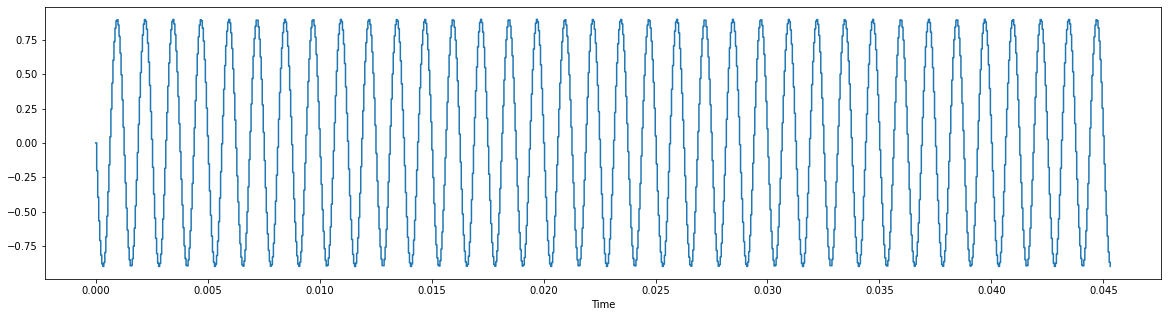

In [25]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(sin3[0:1000], sr=22050)

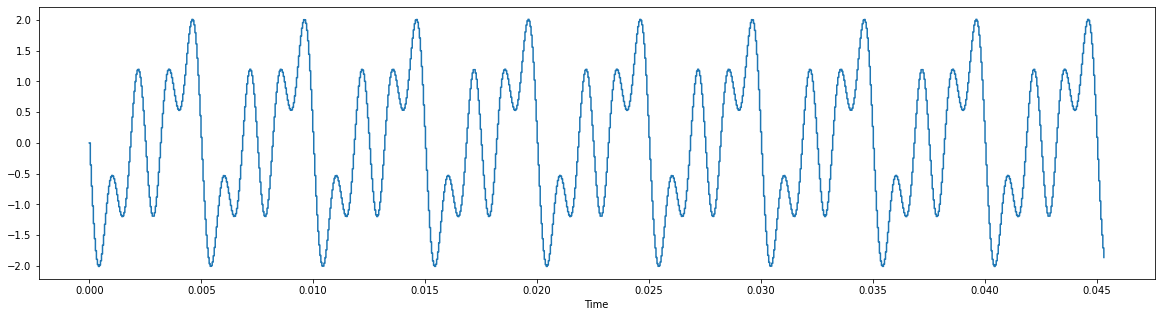

In [26]:
fig = plt.figure(figsize = (20, 5))
librosa.display.waveshow(complexwave[0:1000], sr=22050) # 정현파가 합쳐지면서 복합파가 된 것을 확인할 수 있음

C:\Users\devtae\AppData\Local\Temp/ipykernel_6704/824386184.py:2: FutureWarning: Pass y=[ 1.65327318e-16 -3.57017088e-01 -7.02015431e-01 ...  1.02353859e+00
  7.02015431e-01  3.57017088e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(complexwave, sr=fs, n_mels=128)


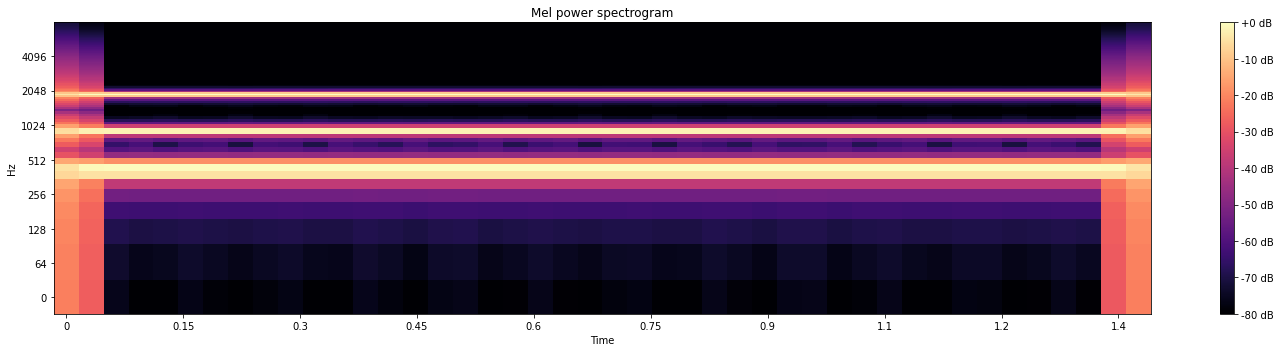

In [27]:
# Spectrogram 을 통하여 해당 음역대 활성화 확인 가능
S = librosa.feature.melspectrogram(complexwave, sr=fs, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
fig = plt.figure(figsize = (20, 5))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='log')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [28]:
# 푸리에 변환 (Fourier transform)
# 임의의 입력 신호를 다양한 주파수를 갖는 주기 함수(복수 지수함수)들의 합으로 분해하여 표현
# Ak = 1/T * sum(-T/2 ~ T/2)(f(t) * exp(-i * 2 * pie * k / T * t)dt)

# 오일러 공식 (지수함수와 주기함수와의 관계)
# cos2pikT, jsin2pikT 함수는 주기와 주파수를 가지는 주기함수이다.
# 즉, 푸리에 변환은 입력 signal이 어떤 것인지 상관 없이 주기함수들의 합으로 항상 분해 가능하다.
# e^(i*θ) = cosθ + i * sinθ
# exp(i * 2pi * k / T * t) = cos(2pi * k / T) + j * sin(2pi * k / T)

# 정리하자면, exponential 한 입력 신호를 주기성을 가지는 함수(cos, sin)의 합으로 나타내어진다.

# 푸리에 변환이 끝나면, 실수부와 허수부를 가지는 복소수가 결과값으로 나온다.
# 복소수의 절대값을 Spectrum magnitude (주파수의 강도), 복소수가 가지는 phase 를 phase spectrum (주파수의 위상) 이라고 한다.
# 즉, 실수부가 Frequency 의 Magnitude, 허수부가 Phase 를 나타낸다고 대략적으로 파악.

In [29]:
# DFT
# yn : input signal, n : Discrete time index, k : discrete frequency index, Yk: k번째 frequency에 대한 spectrum 값
# yn = 1 / N * sum(n = 0 ~ N-1)(Yk * exp(i * 2pi * k / N * n))
# Yk = sum(n = 0 ~ N-1)(yn * exp(-i * 2pi * k / N * n))

# input signal (yn) -> frequency spectrum 또는 함수로 변환 가능
# 특정 주파수를 캐치할 수 있음

In [30]:
def DFT(x):
    N = len(x)
    X = np.array([])
    nv = np.arange(N)
    
    for k in range(N):
        s = np.exp(1j*2*np.pi*k/N*nv) # 1j = i
        X = np.append(X, sum(x*np.conjugate(s))) # conjugate 켤레복소수
    return X

In [31]:
#dftcom = DFT(sin) # 계산 시간이 상당히 긺
#print(dftcom)

In [32]:
# STFT (Short time Fourier Transform)
# FFT 는 시간의 흐름에 따라 주파수의 변화를 모르는데, 시간의 길이를 나눠 이러한 한계점을 개선한 것이 바로 STFT 임.
# X(l,k) = sum(n = 0 ~ N-1) (w(n) * x(n + lH) * exp^(-2pi*k*n/N))

In [33]:
# n_fft 만큼의 데이터를 hop_length 만큼 겹치도록 훈련
# n_fft 를 1024 로 설정하여 계산 가능 / window 함수 length 와 동일하게 하는 것이 좋음
# hop_length 지정은 1/2, 1/4, 0 원하는 수치로 설정
# hop_length 를 줄이면 time domain 값이 증가 / 늘리면 time domain 감소
# 적당히 수정하여 접근 가능함
# 1024, 512, 1024 일반적으로 많이 쓰이는 조합
# 513*327 하면 원래 audioData.shape 값과 비슷해지는데 연관성이 있을까?
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
S.shape, len(S[0]), S[0][0]

((513, 327), 327, (0.06546696+0j))

In [34]:
# phase 에 대한 정보를 날림
D = np.abs(S)**2
D.shape

(513, 327)

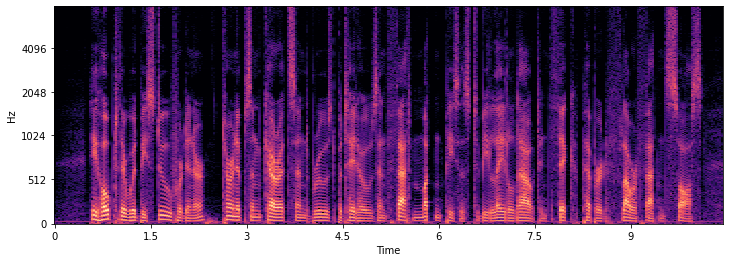

In [35]:
# STFT 실행 후 phase 를 날린(!) 데이터를 시각화
log_D = librosa.power_to_db(D, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_D, sr=sr, x_axis='time', y_axis='mel')

In [51]:
# librosa 를 활용하여 stft, amplitude_to_db 계산 적용
audioData_stft = librosa.stft(audioData.numpy()) # 위 DFT 함수보다 타임 도메인이 2 배로 늘어남
print(audioData_stft.shape)

D = librosa.amplitude_to_db(np.abs(audioData_stft), ref=np.max)
print(D.shape)

(1025, 327)
(1025, 327)


Text(0.5, 1.0, 'Linear-frequency power spectrogram')

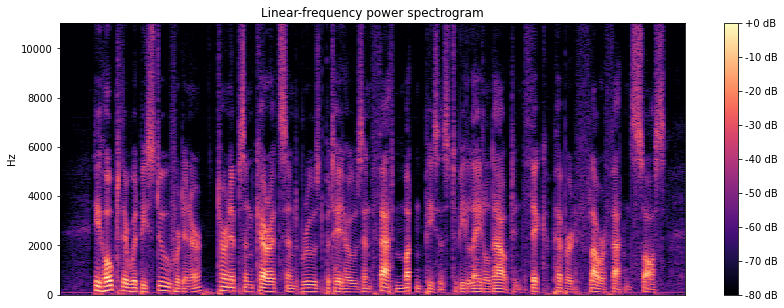

In [37]:
# audioData 에 대한 Spectrogram 출력
# 이런 식으로 librosa 를 통해 sftf 기법으로 변환한 데이터로 딥러닝 학습을 진행하게 됨
fig = plt.figure(figsize = (14,5))
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [38]:
# Window function
# main-lobe의 width와 side-lobe의 라벨의 Trade-off를 제어해준다. 또한, 깁스 현상을 막아준다.

In [39]:
# Frame Audio
# audio 데이터를 2배로 만들어 (reflect (ex. 1234 -> 32123432)) hop_size 만큼 frame 만듦
def frame_audio(audio, FFT_size=1024, hop_size=20, sample_rate=22050):
    audio = np.pad(audio, int(FFT_size/2), mode='reflect') # 양쪽에 FFT_size/2 만큼 붙임. 입력된 신호를 역재생한 것을 이어붙임
    frame_len = np.round(sample_rate*hop_size / 1000).astype(int) # hop_size 늘어날수록 frame_len (길이) 늘어남
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1 # frame 개수
    frames = np.zeros((frame_num, FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    return frames

audio_framed = frame_audio(audio_np)
print("Framed audio shape: {}".format(audio_framed.shape))

Framed audio shape: (379, 1024)


In [40]:
# 저주파 때의 정보가 더 풍부하다
# High-frequency sound - base / Low-frequency sound - apex
# cochlea (반고리관) 저음을 들을수록 펴짐

# Mel-Filter bank
# 사람은 인지기관이 categorical한 구분을 하기 때문에 인접한 주파수를 크게 구별하지 못함
# 멜 스펙트럼은 주파수 단위를 멜 단위로 바꾼 것을 의미
# 진동수가 낮을 때 조밀한 것들에서 높을수록 가중치가 높다

# 따라서, 사람이 인지하는 방식과 동일하게 저음역대에 대한 인식을 더 높이는 방식을 채택
# Mel-Frequency 를 사용했을 때 퍼포먼스가 향상되는 경향이 있다고 함.
# Amplitude 에도 Frequency 의 경우처럼 Filter 를 적용하는 것을 Mu-law encoding 이라고 함.

In [53]:
# STFT
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
# phase 정보 제거
D = np.abs(S)**2

C:\Users\devtae\AppData\Local\Temp/ipykernel_6704/4003911198.py:8: FutureWarning: Pass sr=16000, n_fft=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sr, 1024, n_mels=40) # 40 개의 categorical 한 mel-scaled bin


(40, 327)


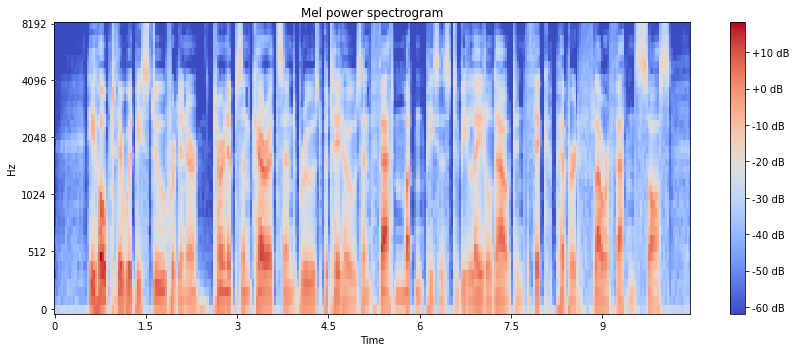

In [54]:
# Mel Spectrogram (512 -> 40) (ex. 40, 92, 128)
# 문제에 따라 n_mels 다른 수치로 접근하는 것은 좋음
# 갖고 있는 데이터 클래스 별로 Spectrogram 을 구하고 평균값을 보고 n_mels 값 정할 수 있음
# 8000hz 까지 올라간다고 한다면 거기까지 구별이 가능할 정도의 mel-bin 을 사용하면 됨
# high-frequency 을 커버하기 위해서는 n_mels 를 잘게 쪼개야겠다는 판단을 할 수 있음
# 저음역대에서는 n_mels 를 작게 설정할 수 있겠다

mel_basis = librosa.filters.mel(sr, 1024, n_mels=40) # 40 개의 categorical 한 mel-scaled bin
mel_S = np.dot(mel_basis, D)
print(mel_S.shape)

fig = plt.figure(figsize=(12,5))
librosa.display.specshow(librosa.power_to_db(mel_S), sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

C:\Users\devtae\AppData\Local\Temp/ipykernel_6704/285671783.py:1: FutureWarning: Pass y=[0.00033569 0.00030518 0.00036621 ... 0.00210571 0.00210571 0.00158691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels=40)


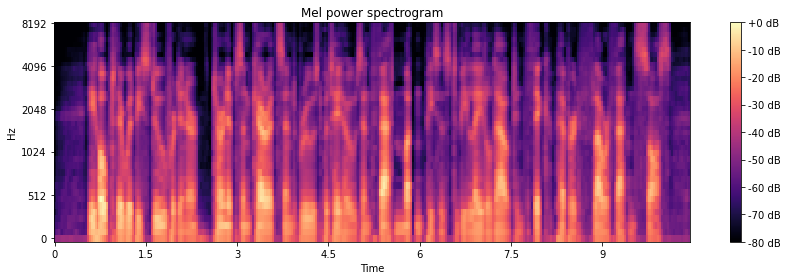

In [43]:
S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels=40)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

C:\Users\devtae\AppData\Local\Temp/ipykernel_6704/243199224.py:1: FutureWarning: Pass y=[0.00033569 0.00030518 0.00036621 ... 0.00210571 0.00210571 0.00158691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels=92)


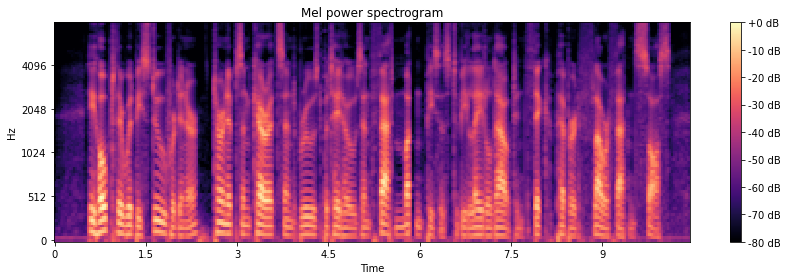

In [44]:
S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels=92)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

C:\Users\devtae\AppData\Local\Temp/ipykernel_6704/2474953871.py:1: FutureWarning: Pass y=[0.00033569 0.00030518 0.00036621 ... 0.00210571 0.00210571 0.00158691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels=128)


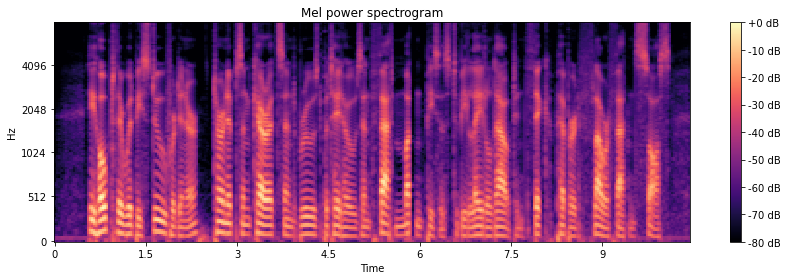

In [45]:
S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [46]:
# 짤막 정리
# waveform 과 spectrogram 은 시간축에 따라 수치를 나타낸 것임.
# waveform 은 amplitude 를 나타내고, spectrogram 은 frequency와 phase를 나타낸다.
# speech recognition, classfication, auto-tagging 에서는 phase는 잘 안 본다고 한다.
# 반대로, speech synthesis 와 speech style transfer 에서는 활용한다고 한다.

# amplitude_to_db 와 power_to_db 사용하는 상황 비교
# dB | Amplitude ratio | Power ratio
# 1 dB | 1.122 | 1.259
# 2 dB | 1.259 | 1.585
# 3 dB | 1.413 | 1.995
# 6 dB | 1.995 | 3.981

# waveform 의 경우 Amplitude ratio 사용하고, notation 을 넣었을 때 Power ratio 를 사용하면 됨.
# 보통 딥러닝 학습할 때, power_to_db 를 안 쓰고 power 를 올리고 power level 에 log 를 취하여 입력으로 쓴다고 함
# 실전에서 사용할 때 참고할 내용으로 삼으면 되겠음
# ex) melspectrogram -> power ... 

In [47]:
# melspectrogram -> log -> Inverse FFT
# spectrogaram -> mel -> MFCC (frequency 압축)

# log compression
# 10 * log10(S/ref) 의 단위로 신호를 스케일링 진행 / spectrogram 을 데시벨 유닛으로 전환
# -> librosa.power_to_db(mel_S)

# MFCC (고유 화자 인식 등에 사용됨)
# Filter Bank는 모두 Overlapping 되어 있어 Filter Bank 에너지들 사이에 상관관계 존재
# Mel-Spectrum 에 log 적용
# Mel-log-Spectrum list 전체에 DCT(Discrete Cosine tranform) 적용함
# 얻어진 Coefficients 에서 앞에서부터 N개만 남기고 버림

# DCT는 n개의 데이터를 n개의 코사인 함수의 합으로 표현하여 데이터의 양을 줄이는 방식
# 저 주파수에 에너지가 집중되고 고 주파수 영역의 에너지가 감소함
# 그 이유로는 Mel 분해를 통해 저 주파수에서 걸리는 신호가 많기 때문일 가능성이 큼
# Filter Bank는 모두 "Overlapping" 되어 있어 Filter Bank 에너지들 사이에 상관관계 존재
# DCT 는 에너지의 상관관계를 제거해주는 역할을 함
# 26개 DCT Coefficient 들 중 12만 남겨야 하는데, 그 이유는 DCT Coefficient 가 많으면, Filter Bank 에너지의 빠른 변화를 나타내고, 음성인식의 성능을 낮추게 된다.

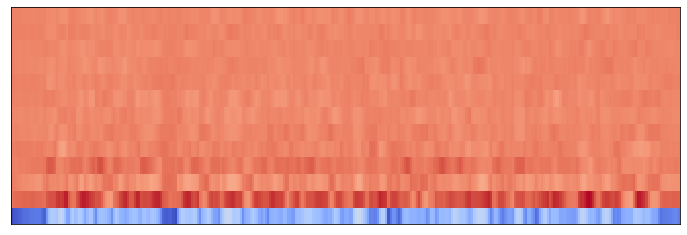

In [76]:
# MFCC (DCT)
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
mfcc = mfcc.astype(np.float32) # to save (64 to 32 bits)
plt.figure(figsize=(12,4))
librosa.display.specshow(mfcc)

(13, 130)


C:\Users\devtae\AppData\Local\Temp/ipykernel_6704/3135489530.py:6: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S_female = librosa.feature.melspectrogram(audioData_female.numpy(), sr=sr_female, n_mels=40)


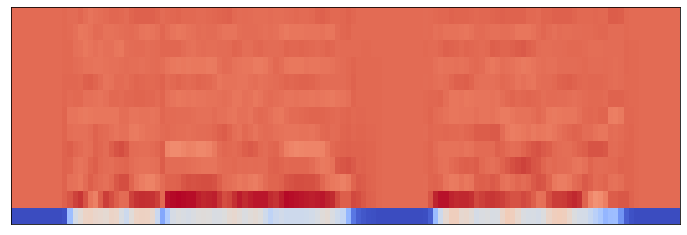

In [71]:
# 화자별로 다르게 나타나는 MFCC 확인
audioData_female = test_dataset[170][0][0]
sr_female = test_dataset[1][1]
ipd.Audio(audioData, rate=sr_female)

S_female = librosa.feature.melspectrogram(audioData_female.numpy(), sr=sr_female, n_mels=40)
log_S_female = librosa.power_to_db(S_female, ref=np.max)
mfcc_female = librosa.feature.mfcc(S=log_S_female, n_mfcc=13)
print(mfcc_female.shape)
plt.figure(figsize=(12,4))
librosa.display.specshow(mfcc_female)

(13, 327)


C:\Users\devtae\AppData\Local\Temp/ipykernel_6704/936272112.py:6: FutureWarning: Pass y=[0.00033569 0.00030518 0.00036621 ... 0.00210571 0.00210571 0.00158691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S_male = librosa.feature.melspectrogram(audioData_male.numpy(), sr=sr_male, n_mels=40)


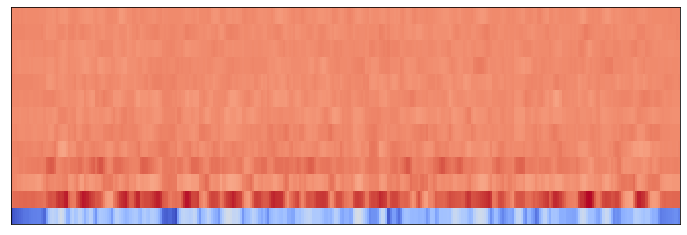

In [70]:
# 화자별로 다르게 나타나는 MFCC 확인
audioData_male = test_dataset[0][0][0]
sr_male = test_dataset[1][1]
ipd.Audio(audioData, rate=sr_male)

S_male = librosa.feature.melspectrogram(audioData_male.numpy(), sr=sr_male, n_mels=40)
log_S_male = librosa.power_to_db(S_male, ref=np.max)
mfcc_male = librosa.feature.mfcc(S=log_S_male, n_mfcc=13)
print(mfcc_male.shape)
plt.figure(figsize=(12,4))
librosa.display.specshow(mfcc_male)